###Лабораторная №5: "Ансамбли моделей машинного обучения".

Киреев Андрей ИУ5-64Б

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from gmdhpy import gmdh
from warnings import simplefilter

simplefilter('ignore')

In [10]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/laptop_price_2.csv')
data.head()

,laptop_ID,Company,Product,TypeName,Inches,Ram_GB,OpSys,Weight_kg,Price_euros,ScreenType,...,ScreenRes,Cpu_type,Cpu_GHz,Gpu_producer,Gpu_model,Memory1_GB,Memory1_type,Memory2_GB,Memory2_type,Memory2
0,1,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,IPS Panel Retina Display,...,2560x1600,Intel Core i5,2.3,Intel,Iris Plus Graphics 640,128,SSD,0,-,-
1,2,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,-,...,1440x900,Intel Core i5,1.8,Intel,HD Graphics 6000,128,Flash Storage,0,-,-
2,3,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,...,1920x1080,Intel Core i5 7200U,2.5,Intel,HD Graphics 620,256,SSD,0,-,-
3,4,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,IPS Panel Retina Display,...,2880x1800,Intel Core i7,2.7,AMD,Radeon Pro 455,512,SSD,0,-,-
4,5,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,IPS Panel Retina Display,...,2560x1600,Intel Core i5,3.1,Intel,Iris Plus Graphics 650,256,SSD,0,-,-


Закодируем категориальные признаки:

In [11]:
category_cols = ['Memory1_type', 'Memory2_type', 'Company', 'Product', 'TypeName', 'OpSys', 
                 'ScreenType', 'Cpu_type', 'Gpu_producer', 'Gpu_model']

print('Количество уникальных значений\n')
for col in category_cols:
    print(f'{col}: {data[col].unique().size}')

Количество уникальных значений

Memory1_type: 4
Memory2_type: 4
Company: 19
Product: 618
TypeName: 6
OpSys: 9
ScreenType: 21
Cpu_type: 93
Gpu_producer: 4
Gpu_model: 110


In [12]:
remove_cols = ['Product', 'Gpu_model', 'Cpu_type']
for col in remove_cols:
    category_cols.remove(col)
data = pd.get_dummies(data, columns=category_cols)
data.drop(remove_cols, axis=1, inplace=True)
data.drop(['laptop_ID', 'ScreenRes', 'Memory2'], axis=1, inplace=True)
data.describe()

,Inches,Ram_GB,Weight_kg,Price_euros,ScreenWidth,ScreenHeight,Cpu_GHz,Memory1_GB,Memory2_GB,Memory1_type_Flash Storage,...,ScreenType_Quad HD+,ScreenType_Quad HD+ / Touchscreen,ScreenType_Touchscreen,ScreenType_Touchscreen / 4K Ultra HD,ScreenType_Touchscreen / Full HD,ScreenType_Touchscreen / Quad HD+,Gpu_producer_AMD,Gpu_producer_ARM,Gpu_producer_Intel,Gpu_producer_Nvidia
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,...,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,15.034880,8.443200,2.046152,1132.177480,1897.272000,1072.256000,2.303856,447.180800,174.675200,0.055200,...,0.002400,0.012000,0.025600,0.000800,0.000800,0.000800,0.133600,0.000800,0.552000,0.313600
std,1.416838,5.121929,0.669436,703.965444,491.854703,283.172078,0.502772,367.670259,411.340426,0.228462,...,0.048951,0.108929,0.158002,0.028284,0.028284,0.028284,0.340358,0.028284,0.497488,0.464142
min,10.100000,2.000000,0.690000,174.000000,1366.000000,768.000000,0.900000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,4.000000,1.500000,600.425000,1600.000000,900.000000,2.000000,256.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.600000,8.000000,2.040000,985.000000,1920.000000,1080.000000,2.500000,256.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,15.600000,8.000000,2.310000,1489.747500,1920.000000,1080.000000,2.700000,512.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,18.400000,64.000000,4.700000,6099.000000,3840.000000,2160.000000,3.600000,2048.000000,2048.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 76 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Inches                                          1250 non-null   float64
 1   Ram_GB                                          1250 non-null   int64  
 2   Weight_kg                                       1250 non-null   float64
 3   Price_euros                                     1250 non-null   float64
 4   ScreenWidth                                     1250 non-null   int64  
 5   ScreenHeight                                    1250 non-null   int64  
 6   Cpu_GHz                                         1250 non-null   float64
 7   Memory1_GB                                      1250 non-null   int64  
 8   Memory2_GB                                      1250 non-null   int64  
 9   Memory1_type_Flash Storage               

Выведем матрицу корреляций:

In [14]:
print('Целевой признак - цена ноутбука')
best_params = data.corr()['Price_euros'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.4]
best_params

Целевой признак - цена ноутбука


Ram_GB               0.743141
TypeName_Notebook    0.555495
ScreenWidth          0.553660
ScreenHeight         0.550213
Memory1_type_SSD     0.505318
ScreenType_-         0.435191
Cpu_GHz              0.431697
Memory1_type_HDD     0.425687
Name: Price_euros, dtype: float64

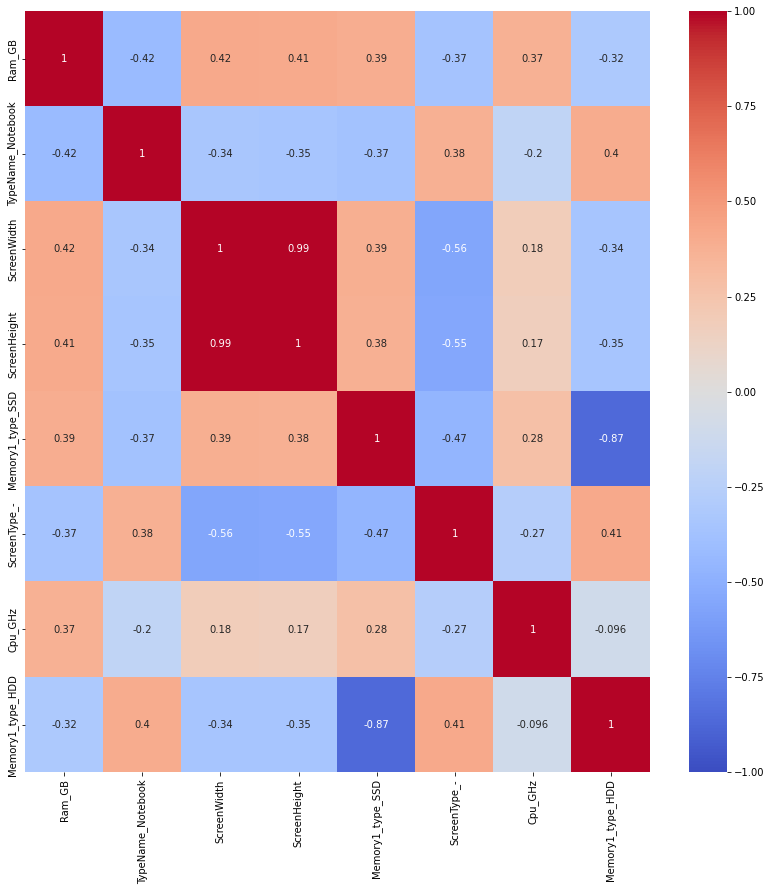

In [15]:
plt.figure(figsize=(14, 14))
sns.heatmap(data[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

In [17]:
best_params = best_params.drop(['ScreenHeight', 'Memory1_type_SSD', 'ScreenType_-'])

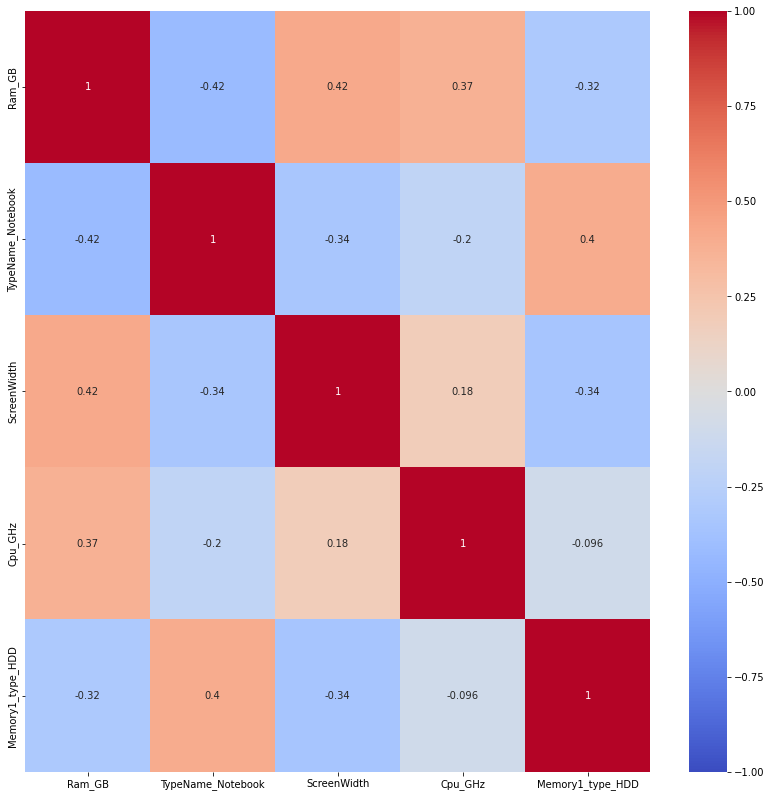

In [18]:
plt.figure(figsize=(14, 14))
sns.heatmap(data[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

Разделение выборки на обучающую и тестовую

In [19]:
y = data['Price_euros']
X = data[best_params.index]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

Масштабирование данных

In [20]:
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)

Функция вывода метрик:

In [21]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

1) Случайный лес (RandomForestRegressor)

In [22]:
print_metrics(y_test, RandomForestRegressor(random_state=17).fit(x_train, y_train).predict(x_test))

R^2: 0.6968750911812078
MSE: 131254.4602379803
MAE: 254.91965560764027


Подбор гиперпараметров:

In [23]:
rf = RandomForestRegressor(random_state=17)
params = {'n_estimators': [100, 1000], 'criterion': ['squared_error', 'absolute_error', 'poisson'], 
          'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 3, 5]}
grid_cv = GridSearchCV(estimator=rf, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'criterion': 'absolute_error', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}


In [24]:
best_rf = grid_cv.best_estimator_
best_rf.fit(x_train, y_train)
y_pred_rf = best_rf.predict(x_test)
print_metrics(y_test, y_pred_rf)

R^2: 0.7012154850829543
MSE: 129375.0499941507
MAE: 251.69142770666673


2) Градиентный бустинг (GradientBoostingRegressor)

In [25]:
print_metrics(y_test, GradientBoostingRegressor(random_state=17).fit(x_train, y_train).predict(x_test))

R^2: 0.6899163393300718
MSE: 134267.63134856336
MAE: 261.78800590675905


Подбор гиперпараметров:

In [26]:
gb = GradientBoostingRegressor(random_state=17)
params = {'loss': ['squared_error', 'absolute_error', 'huber'], 'n_estimators': [10, 50, 100, 200], 
          'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'], 'min_samples_leaf': [1, 3, 5]}
grid_cv = GridSearchCV(estimator=gb, cv=5, param_grid=params, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'criterion': 'friedman_mse', 'loss': 'huber', 'min_samples_leaf': 1, 'n_estimators': 100}


In [28]:
best_gb = grid_cv.best_estimator_
best_gb.fit(x_train, y_train)
y_pred_gb = best_gb.predict(x_test)
print_metrics(y_test, y_pred_gb)

R^2: 0.6941685868528518
MSE: 132426.388886584
MAE: 257.3342487269434


3) Стекинг (LinearRegression + RandomForestRegressor + GradientBoostingRegressor)

In [29]:
!pip install heamy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for heamy: filename=heamy-0.0.7-py2.py3-none-any.whl size=15366 sha256=f024dd409a1863ae1e4de8924897c9a64982cb1eed5d647d0b43f24158d48d12
  Stored in directory: /root/.cache/pip/wheels/f5/6c/da/55718ad26a9c8d3528b50edc2676fb33b0fb2e2b04e54cc882
Successfully built heamy


In [32]:
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [33]:
dataset = Dataset(x_train, y_train, x_test)
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, 
                     parameters={'criterion': 'absolute_error', 'n_estimators': 1000, 'random_state': 17}, name='rf')
pipeline = ModelsPipeline(model_lr, model_rf)
stack_ds = pipeline.stack(k=10, seed=1)
stacker = Regressor(dataset=stack_ds, estimator=GradientBoostingRegressor)
results = stacker.validate(k=10, scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [224.9807596970294, 225.14414799175867, 225.08305028534406, 287.6436634541922, 286.9800907471907, 238.23279727065287, 264.3044983354745, 275.7212300756112, 208.97566572527478, 270.62500915322886]
Mean accuracy: 250.76909127357573
Standard Deviation: 27.850210157356006
Variance: 775.6342058088957


In [34]:
y_pred_stack = stacker.predict()
print_metrics(y_test, y_pred_stack)

R^2: 0.6550524570825187
MSE: 149363.8504749785
MAE: 270.419536388916


Сравним модели по метрикам:

In [35]:
print("Случайный лес")
print_metrics(y_test, y_pred_rf)

print("\nГрадиентный бустинг")
print_metrics(y_test, y_pred_gb)

print("\nСтекинг")
print_metrics(y_test, y_pred_stack)

Случайный лес
R^2: 0.7012154850829543
MSE: 129375.0499941507
MAE: 251.69142770666673

Градиентный бустинг
R^2: 0.6941685868528518
MSE: 132426.388886584
MAE: 257.3342487269434

Стекинг
R^2: 0.6550524570825187
MSE: 149363.8504749785
MAE: 270.419536388916


Вывод: Несмотря на высокую среднеквадратическую ошибку, у метода Случайный лес показатели ошибок меньше всего. Коэффициент детерминации у Случайного леса также ближе всех  к единице. Значит этот метод для обучения на данном датасете более предпочтителен.